In [1]:
import pandas as pd
import numpy as np
import math 
import operator
from scipy import cluster
from scipy.spatial import distance
import matplotlib.pyplot as plt


In [35]:
class gnKNN(object):
    
    def __init__(self, eta=0.05, n_iter=10, batchSize = 16, random_state=1, kSize = 3, inits = "Random", run = 10, tolerance = .001):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        self.batch_size = batchSize
        self.rgen = np.random.RandomState(self.random_state)
        self.kSize = kSize
        self.z =  [[] for _ in range(kSize)]
        self.group = []
        self.cost_ = []
        self.inits = inits
        self.run = run
        self.glob_cost = 0
        self.glob_group = []
        self.glob_z = []
        self.tolerance = tolerance
    
    def fit(self, x, y):
        for runns in np.arange(self.run):
            
            costs = [[] for _ in range(self.kSize)]
            self.z = [[] for _ in range(self.kSize)]
            
            #initalize either random or Kmean++
            if self.inits == "Random":
                centrods = self.Randoming(self.kSize, x)
            if self.inits == "KmeanPlus":
                centrods = self.Randoming(self.kSize, x)

            for iters in np.arange(self.n_iter):
                self.group = []
                for trials in np.arange(len(x)):
                    dist2 = []
                    for ks in np.arange(self.kSize):
                        dist2.append(distance.euclidean(x[trials], self.z[ks]))
                    self.group.append(np.argmin(dist2))

                for ks in np.arange(self.kSize):
                    self.z[ks] = self.centroiding(x[np.array(self.group) == ks])
                    costs[ks] = sum([(x - self.z[ks])**2 for x in x[np.array(self.group) == ks]])

                self.cost_.append(sum(sum(costs)))
                if self.cost_[-1] - self.glob_cost < self.tolerance:
                    break
                
            if runns == 1:
                self.glob_cost = self.cost_[0]
                self.glob_group = self.group
                self.glob_z = self.z
            else:
                if self.cost_[-1] < self.glob_cost:
                    self.glob_cost = self.cost_[-1]
                    self.glob_group = self.group
                    self.glob_z = self.z         
        return self
        
        
    def Randoming(self, kSize, x):
        batchSize = math.floor(len(x)/kSize)
        r = self.rgen.permutation(len(x))
        temp_x = x[r]
        for nums in np.arange(kSize):
            self.z[nums].append(np.mean(x[0+batchSize*nums:batchSize*(nums+1)], axis =0))            
        return self.z
    
    def centroiding(self, x):
        return(np.mean(x, axis = 0))
    
    def KMeanPlus(self, kSize, x):
        r = self.rgen.permutation(len(x))
        temp_x = x[r]
        self.z[0] = x[0]
        for nums in range(1,self.kSize):
            r = self.rgen.permutation(len(x))
            temp_x = x[r]
            self.ds = [distance.euclidean(x, self.z[0]) for x in temp_x[nums:]]
            pdf = np.cumsum(np.round(np.exp2(fs.ds)/sum(np.exp2(fs.ds)),2))
            temp_ind = np.random.choice(pdf)
            pdflist = pdf.tolist()
            self.z[nums] = (x[pdflist.index(temp_ind)])            
        return self.z
    

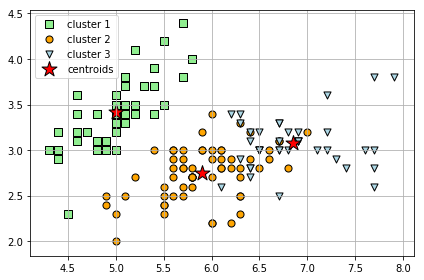

In [3]:
"Kmeans from the sklearn"

from sklearn.cluster import KMeans

df = pd.read_csv('https://archive.ics.uci.edu/ml/'
        'machine-learning-databases/iris/iris.data', header=None)

x = df.iloc[:,0:4].values
y = df.iloc[:,4]


km = KMeans(n_clusters=3, 
            init='random', 
            n_init=10, 
            max_iter=100,
            tol=1e-04,
            random_state=0)

y_kmSK = km.fit_predict(x)


plt.scatter(x[y_kmSK == 0, 0],
            x[y_kmSK == 0, 1],
            s=50, c='lightgreen',
            marker='s', edgecolor='black',
            label='cluster 1')
plt.scatter(x[y_kmSK == 1, 0],
            x[y_kmSK == 1, 1],
            s=50, c='orange',
            marker='o', edgecolor='black',
            label='cluster 2')
plt.scatter(x[y_kmSK == 2, 0],
            x[y_kmSK == 2, 1],
            s=50, c='lightblue',
            marker='v', edgecolor='black',
            label='cluster 3')
plt.scatter(km.cluster_centers_[:, 0],
            km.cluster_centers_[:, 1],
            s=250, marker='*',
            c='red', edgecolor='black',
            label='centroids')
plt.legend(scatterpoints=1)
plt.grid()
plt.tight_layout()
#plt.savefig('images/11_02.png', dpi=300)
plt.show()

The percentage of the same classification between generic Kmean and sklearn Kmean
0.9933333333333333


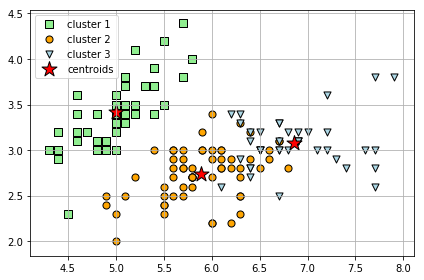

In [10]:
"Kmean from generic python"

df = pd.read_csv('https://archive.ics.uci.edu/ml/'
        'machine-learning-databases/iris/iris.data', header=None)

x = df.iloc[:,0:4].values
y = df.iloc[:,4]

km = gnKNN(n_iter=100, kSize = 3).fit(x,y)


y_km = np.array(km.glob_group)
cluster_centers_ = np.vstack(km.glob_z)

plt.scatter(x[y_km == 0, 0],
            x[y_km == 0, 1],
            s=50, c='lightgreen',
            marker='s', edgecolor='black',
            label='cluster 1')
plt.scatter(x[y_km == 1, 0],
            x[y_km == 1, 1],
            s=50, c='orange',
            marker='o', edgecolor='black',
            label='cluster 2')
plt.scatter(x[y_km == 2, 0],
            x[y_km == 2, 1],
            s=50, c='lightblue',
            marker='v', edgecolor='black',
            label='cluster 3')

plt.scatter(cluster_centers_[:, 0],
            cluster_centers_[:, 1],
            s=250, marker='*',
            c='red', edgecolor='black',
            label='centroids')

plt.legend(scatterpoints=1)
plt.grid()
plt.tight_layout()

print("The percentage of the same classification between generic Kmean and sklearn Kmean")
print(np.mean(km.glob_group == y_kmSK))


In [36]:
distortions = []
for i in range(1, 8):
    km = gnKNN(kSize=i,
               n_iter = 10,
               run=10,
               tolerance = 1e-04

              )
    km.fit(x,y)
    distortions.append(km.glob_cost)
plt.plot(range(1, 8), distortions, marker='o')
plt.title('Generic Kmean - random')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
#plt.savefig('images/11_03.png', dpi=300)
plt.show()


distortions = []
for i in range(1, 8):
    km = gnKNN(kSize=i,
               n_iter = 10,
               run=10,
               inits = "KmeanPlus",
               tolerance = 1e-04

              )
    km.fit(x,y)
    distortions.append(km.glob_cost)
plt.plot(range(1, 8), distortions, marker='o')
plt.title('Generic Kmean - kmeanPlus')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
#plt.savefig('images/11_03.png', dpi=300)
plt.show()




distortions = []
for i in range(1, 8):
    km = KMeans(n_clusters=i, 
                init='random', 
                n_init=10, 
                max_iter=10,
                tol=1e-04,
                random_state=1)

    y_km = km.fit_predict(x)

    distortions.append(km.inertia_)
plt.plot(range(1, 8), distortions, marker='o')
plt.title('sklearn Kmean')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
#plt.savefig('images/11_03.png', dpi=300)
plt.show()




TypeError: only integer scalar arrays can be converted to a scalar index

The percentage of the same classification between generic Kmean and Sklearn Kmean was not different ( <1%). Elbow method suggests that cluster level of three is sufficient for classifying the data. KmeanPlus does not seem to be outperforming and there seem to be ceiling effect due to the type of the data. 

In [34]:
"siloutte"

from sklearn.metrics import silhouette_samples
from matplotlib import cm
print("Random")
for i in range(2,6):
    km = gnKNN(n_iter=10, kSize = i).fit(x,y)
    y_km = np.array(km.glob_group)

    cluster_labels = np.unique(y_km)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(x, y_km, metric='euclidean')
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0,
        edgecolor='none', color=color)
        yticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette_vals)

    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color="red", linestyle="--")
    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')
    plt.tight_layout()
    #plt.savefig('images/11_04.png', dpi=300)
    plt.show()

print("KMean Plus")
for i in range(2,6):
    km = gnKNN(n_iter=10, kSize = i, inits = "KmeanPlus").fit(x,y)
    y_km = np.array(km.glob_group)

    cluster_labels = np.unique(y_km)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(x, y_km, metric='euclidean')
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0,
        edgecolor='none', color=color)
        yticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette_vals)

    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color="red", linestyle="--")
    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')
    plt.tight_layout()
    #plt.savefig('images/11_04.png', dpi=300)
    plt.show()



Random


TypeError: only integer scalar arrays can be converted to a scalar index

while the elbow method suggests cluster level of three is sufficient, the siloutte method suggests suboptimal clustering. Yet, the siloutte method suggests either three or four are the best cluster levels.

In [20]:
class fuzyKNN(object):
    
    def __init__(self, eta=0.05, n_iter=10, batchSize = 16, random_state=1, kSize = 3, inits = "Random", run = 10, tolerance = .001, fuzz = 2):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        self.batch_size = batchSize
        self.rgen = np.random.RandomState(self.random_state)
        self.kSize = kSize
        self.z =  [[] for _ in range(kSize)]
        self.group = []
        self.cost_ = []
        self.inits = inits
        self.run = run
        self.glob_cost = []
        self.glob_group = []
        self.glob_z = []
        self.tolerance = tolerance
        self.fuzz = fuzz-1
        self.w_ = []
    
    def fit(self, x, y):
        for runns in np.arange(self.run):
            
            costs = [[] for _ in range(self.kSize)]
            self.z = [[] for _ in range(self.kSize)]
            
            #initalize either random or Kmean++
            if self.inits == "Random":
                centrods = self.Randoming(self.kSize, x)
            if self.inits == "KmeanPlus":
                centrods = self.Randoming(self.kSize, x)

            for iters in np.arange(self.n_iter):
                self.group = []
                self.w_ = self.weighting(x)
                self.w_ = np.round(self.w_,3)
                for trials in np.arange(len(x)):
                    dist2 = []
                    for ks in np.arange(self.kSize):
                        temp_w = self.w_[trials,ks]**(self.fuzz+1)
                        if temp_w < 0.001:
                            temp_w = 0.001
                        dist2.append((temp_w*(distance.euclidean(x[trials], self.z[ks]))))
                        
                    self.group.append(np.argmax(dist2))
                    
                costs_ = [[] for _ in range(self.kSize)]

                for ks in np.arange(self.kSize):
                    self.z[ks] = self.clustering(self.w_[:,ks], x)
                    for xi in np.arange(len(x)):            
                        temp_w = self.w_[xi,ks]**(self.fuzz+1)
                        if temp_w < 0.001:
                            temp_w = 0.001
                        costs += np.sum(temp_w*(distance.euclidean(x[xi], self.z[ks])))
                    costs_[ks].append(costs)
                        
                self.cost_.append(np.sum(costs_))
                if self.cost_[-1] - self.glob_cost < self.tolerance:
                    break
                
            if runns == 1:
                self.glob_cost = self.cost_[0]
                self.glob_group = self.group
                self.glob_z = self.z
            else:
                if self.cost_[-1] < self.glob_cost:
                    self.glob_cost = self.cost_[-1]
                    self.glob_group = self.group
                    self.glob_z = self.z         
        return self
        
        
    def Randoming(self, kSize, x):
        batchSize = math.floor(len(x)/kSize)
        r = self.rgen.permutation(len(x))
        temp_x = x[r]
        for nums in np.arange(kSize):
            self.z[nums].append(np.mean(x[0+batchSize*nums:batchSize*(nums+1)], axis =0))            
        return self.z
    
    def centroiding(self, x):
        return(np.mean(x, axis = 0))
    
    def clustering(self, w, x):
        "input w : 1Xn weight vector of a cluster"
        "input x : data X"
        centroids = [[] for _ in range(len(x))]
        sumW = sum(w)**(self.fuzz+1)
        for nums in np.arange(len(x)):
            tempD = (w[nums]**(self.fuzz+1))*x[nums]
            centroids[nums].append(tempD)
        
        centroids = np.vstack(np.array(centroids))
        return sum(centroids)/sumW
        
        
        
            
        
    

    def weighting(self, x):
        "input : input data X"
        "output : returning 150Xself.kSize(numCluster)"
                    
        self.w = [[] for _ in range(len(x))]
        for lengths in np.arange(len(x)):
            
            tempW = []
            for clvls in np.arange(self.kSize):
                
                tempD = distance.euclidean(x[lengths],self.z[clvls])
                tempD = tempD**(2/(self.fuzz))
                tempW.append(tempD)
            for clvls in np.arange(self.kSize):
                tempW[clvls] = ((tempW[clvls]/tempW[0])**(2/self.fuzz) 
                                + tempW[clvls]/tempW[1]**(2/self.fuzz) 
                                + tempW[clvls]/tempW[2]**(2/self.fuzz))
                
            self.w[lengths] = np.array(tempW)**(-1)
            
       
              
        return np.vstack(np.array(self.w))
    
    def KMeanPlus(self, kSize, x):
        r = self.rgen.permutation(len(x))
        temp_x = x[r]
        self.z[0] = x[0]
        for nums in range(1,self.kSize):
            r = self.rgen.permutation(len(x))
            temp_x = x[r]
            self.ds = [distance.euclidean(x, self.z[0]) for x in temp_x[nums:]]
            pdf = np.cumsum(np.round(np.exp2(fs.ds)/sum(np.exp2(fs.ds)),2))
            temp_ind = np.random.choice(pdf)
            pdflist = pdf.tolist()
            self.z[nums] = (x[pdflist.index(temp_ind)])            
        return self.z

C:\Users\kkim\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
C:\Users\kkim\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


The percentage of the same classification between generic Kmean and sklearn Kmean
0.3466666666666667


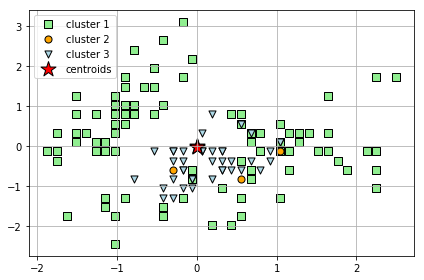

In [27]:
"Kmean from generic python"
from sklearn.preprocessing import StandardScaler
df = pd.read_csv('https://archive.ics.uci.edu/ml/'
        'machine-learning-databases/iris/iris.data', header=None)


X = df.iloc[:,0:4].values
y = df.iloc[:,4]

sc = StandardScaler()
sc.fit(X)
x = sc.transform(X)


km = fuzyKNN(n_iter=100, kSize = 3).fit(x,y)


y_km = np.array(km.glob_group)
cluster_centers_ = np.vstack(km.glob_z)

plt.scatter(x[y_km == 0, 0],
            x[y_km == 0, 1],
            s=50, c='lightgreen',
            marker='s', edgecolor='black',
            label='cluster 1')
plt.scatter(x[y_km == 1, 0],
            x[y_km == 1, 1],
            s=50, c='orange',
            marker='o', edgecolor='black',
            label='cluster 2')
plt.scatter(x[y_km == 2, 0],
            x[y_km == 2, 1],
            s=50, c='lightblue',
            marker='v', edgecolor='black',
            label='cluster 3')

plt.scatter(cluster_centers_[:, 0],
            cluster_centers_[:, 1],
            s=250, marker='*',
            c='red', edgecolor='black',
            label='centroids')

plt.legend(scatterpoints=1)
plt.grid()
plt.tight_layout()

print("The percentage of the same classification between generic Kmean and sklearn Kmean")
print(np.mean(km.glob_group == y_kmSK))

Random


C:\Users\kkim\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
C:\Users\kkim\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


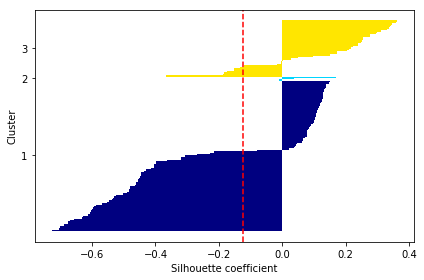

In [32]:
"siloutte"

from sklearn.metrics import silhouette_samples
from matplotlib import cm
print("Random")

km = fuzyKNN(n_iter=10, kSize = 3).fit(x,y)
y_km = np.array(km.glob_group)

cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(x, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0,
    edgecolor='none', color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)

silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--")
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.tight_layout()
#plt.savefig('images/11_04.png', dpi=300)
plt.show()

Based on the result of siloutte, my code has failed miserably. I tried my best to fix it, but I am not so sure where it was broken. Also, I am not so sure how to adjust the shape of denominator based on the number of clusters when I need to calculate the weight. The number of the denominators can vary depending on the given cluster size. I am not equipped with the ability to handle that issue. 